# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
from pprint import pprint

In [2]:
import covsirphy as cs
cs.__version__

'2.17.0'

### Dataset preparation
Download the datasets to "../input" directory and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [3]:
data_loader = cs.DataLoader("../input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu()
# Population in each country
population_data = data_loader.population()
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()
# The number of tests
pcr_data = data_loader.pcr()
# The number of vaccinations
vaccine_data = data_loader.vaccine()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan. `covsirphy.Scenario` is the interface for analysis. Please specify the area (country: required, province: optional) and register the datasets. From version 2.17.0, we use `Scenario.register()` method to register datasets.

In [4]:
# Specify country and province (optinal) names
snl = cs.Scenario(country="Japan", province=None)
# Register datasets
snl.register(jhu_data, population_data, extras=[oxcgrt_data, pcr_data, vaccine_data])

We call `JHUData` and `PopulationData` as "the main datasets" because they are required to calculate the number of susceptible/infected/recovered/fatal cases. These variables are used in SIR-F model.  
The other datasets are called as "the extra datasets" and they will be used to predict the futute parameter values of SIR-F model for forecasting the number of cases with some scenarios.

Additional information:  

- Details of the datasets: [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html)
- Details of SIR-F model: [Usage: SIR-derived models](https://lisphilar.github.io/covid19-sir/usage_theoretical.html)

#### Display/save figures
We have intactive mode and script mode to display/save figures.

Interactive mode:  
This is recommended when we use interactive shells, including Jupyter Notebook, for analysis. Figures will be displayed.

In [5]:
# Show figures (default is True when we use interactive shells)
snl.interactive = True
# If you do not want to display figures for selected methods, please apply "show_figures=False"
# snl.records(show_figure=False)

Script mode:  
This will be forced when we use CovsirPhy with scripts. Figures will be shown when filename is specified.

In [6]:
# Stop displaying figures
# snl.interactive = False
# With this mode we can save figures with "filename" argument
# snl.records(filename="records.jpg")

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

`Scenario.records()` shows the number of infected/recovered/fatal cases as default. Using `variables` argument, we can set the variables to show.

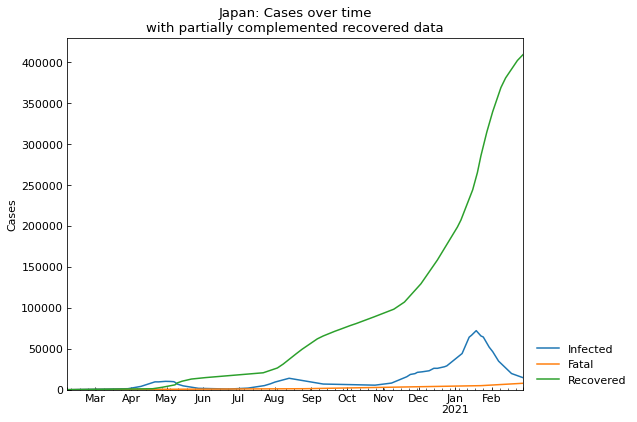

,Date,Infected,Fatal,Recovered
384,2021-02-24,16502,7584,403381
385,2021-02-25,15649,7647,405257
386,2021-02-26,15166,7722,406584
387,2021-02-27,14712,7807,408020
388,2021-02-28,14561,7860,409319


In [7]:
# Show main variables
snl.records().tail()
# We can select variables to show
# snl.records(variables=["Confirmed", "Recovered"])

All available variables can be retrieved with `variables="all"`.

In [8]:
# All available variables for the registered datasets
df = snl.records(variables="all", show_figure=False)
pprint(df.set_index("Date").columns.tolist(), compact=True)

['Confirmed', 'Infected', 'Fatal', 'Recovered', 'Susceptible', 'School_closing',
 'Workplace_closing', 'Cancel_events', 'Gatherings_restrictions',
 'Transport_closing', 'Stay_home_restrictions',
 'Internal_movement_restrictions', 'International_movement_restrictions',
 'Information_campaigns', 'Testing_policy', 'Contact_tracing',
 'Stringency_index', 'Tests', 'Vaccinations', 'Vaccinated_once',
 'Vaccinated_full']


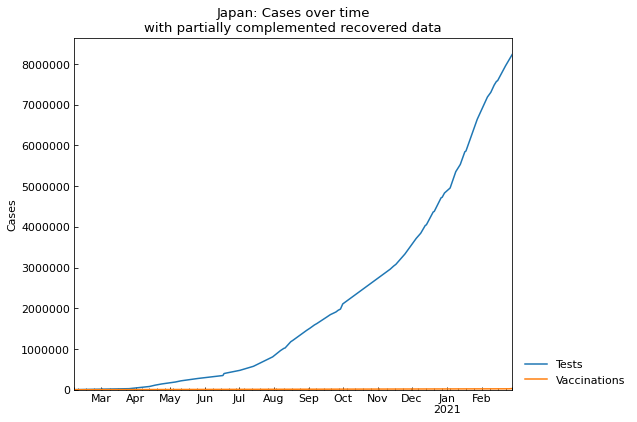

,Date,Tests,Vaccinations
384,2021-02-24,8026999,17888
385,2021-02-25,8083230,21896
386,2021-02-26,8143924,28530
387,2021-02-27,8203285,28530
388,2021-02-28,8234982,28530


In [9]:
# We can select the varialbles of both of the main and extra datasets if registered
snl.records(variables=["Tests", "Vaccinations"]).tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

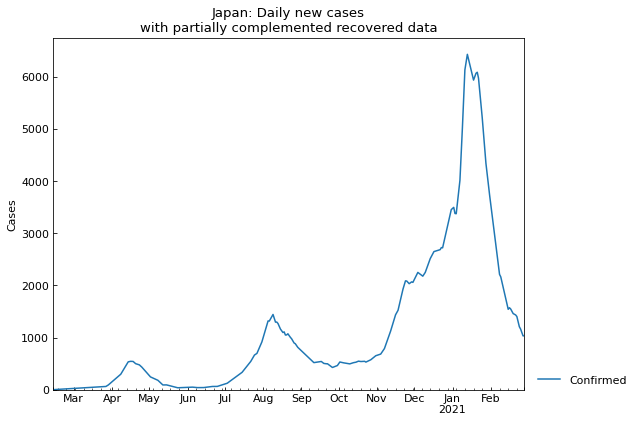

In [10]:
# Acceptable variables are the same as Scenario.records()
_ = snl.records_diff(variables=["Confirmed"], window=7)

`Scenario.show_complement()` method is useful to show the kinds of complement. The details of complement are explained in [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html#The-number-of-cases-(JHU-style)) section.

In [11]:
# Show the details of complement
snl.show_complement()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Japan,-,False,False,True,False,True


### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html). Phases will be separated with dotted lines.

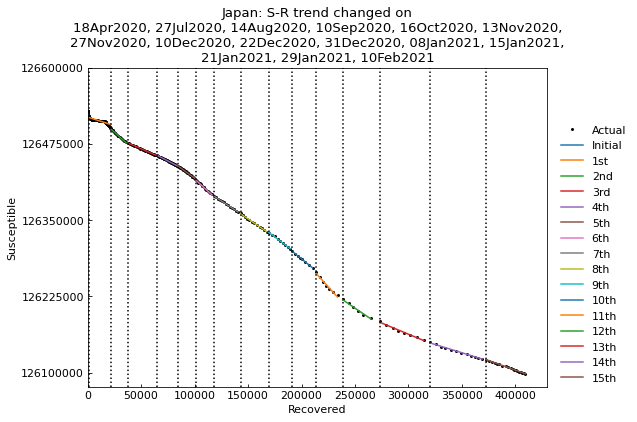

,Type,Start,End,Population
0th,Past,06Feb2020,17Apr2020,126529100
1st,Past,18Apr2020,26Jul2020,126529100
2nd,Past,27Jul2020,13Aug2020,126529100
3rd,Past,14Aug2020,09Sep2020,126529100
4th,Past,10Sep2020,15Oct2020,126529100
5th,Past,16Oct2020,12Nov2020,126529100
6th,Past,13Nov2020,26Nov2020,126529100
7th,Past,27Nov2020,09Dec2020,126529100
8th,Past,10Dec2020,21Dec2020,126529100
9th,Past,22Dec2020,30Dec2020,126529100


In [12]:
# Perform S-R trend analysis and set phases
_ = snl.trend()
# Show the summary of phases
snl.summary()
# Or,
# snl.trend().summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).  

**We can select the model from SIR, SIRD and SIR-F model for parameter estimation. SIR-FV model (completely deprecated) and SEWIR-F model cannot be used.**

In [13]:
# Estimate the parameter values of SIR-F model
# Default value of timeout is 180 sec
snl.estimate(cs.SIRF, timeout=180)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	15th phase (10Feb2021 - 28Feb2021): finished  357 trials in 0 min 20 sec


	 7th phase (27Nov2020 - 09Dec2020): finished  184 trials in 0 min 20 sec

	 4th phase (10Sep2020 - 15Oct2020): finished  366 trials in 0 min 40 sec

	 8th phase (10Dec2020 - 21Dec2020): finished  373 trials in 0 min 40 sec

	 3rd phase (14Aug2020 - 09Sep2020): finished  591 trials in 1 min 10 sec

	 0th phase (06Feb2020 - 17Apr2020): finished  628 trials in 1 min 11 sec

	 5th phase (16Oct2020 - 12Nov2020): finished  670 trials in 1 min 21 sec

	10th phase (31Dec2020 - 07Jan2021): finished  241 trials in 0 min 30 sec

	 6th phase (13Nov2020 - 26Nov2020): finished  660 trials in 1 min 31 sec

	13th phase (21Jan2021 - 28Jan2021): finished  171 trials in 0 min 20 sec

	14th phase (29Jan2021 - 09Feb2021): finished  207 trials in 0 min 20 sec

	 9th phase (22Dec2020 - 30Dec2020): finished  880 trials in 1 min 31 sec

	12th phase (15Jan2021 - 20Jan2021): finished  927 trials in 1 min 30 sec

	11th phase (08Jan2021 - 14Jan2021): finished 1056 trials in 1 min 41 sec

	 1st phase (18Apr2020 - 26Jul2020): finished 1531 trials in 3 min  2 sec

	 2nd phase (27Jul2020 - 13Aug2020): finished 1618 trials in 3 min  2 sec

Completed optimization. Total: 3 min 26 sec


In [14]:
# Show the summary of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,5.89,0.017203,0.000284,0.049220,0.007931,720,0.017,1761,10,63,0.310062,628,1 min 11 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.64,0.047268,0.000508,0.021406,0.031197,720,0.047,983,23,16,0.479196,1531,3 min 2 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.76,0.000824,0.000085,0.060365,0.034138,720,0.001,5900,8,14,0.045761,1618,3 min 2 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000197,0.000568,0.038515,0.048723,720,0.000,880,12,10,0.024944,591,1 min 10 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.91,0.000791,0.000557,0.044613,0.048547,720,0.001,898,11,10,0.028962,366,0 min 40 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.17,0.000447,0.000596,0.053973,0.045678,720,0.000,839,9,10,0.055113,670,1 min 21 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.68,0.001074,0.000235,0.064778,0.038355,720,0.001,2128,7,13,0.019185,660,1 min 31 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.16,0.000349,0.000709,0.049361,0.041837,720,0.000,705,10,11,0.016854,184,0 min 20 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.23,0.015486,0.000070,0.051766,0.041480,720,0.015,7134,9,12,0.014074,373,0 min 40 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.29,0.000394,0.000815,0.050140,0.038165,720,0.000,613,9,13,0.015898,880,1 min 31 sec


### Evaluation of estimation accuracy
Accuracy of parameter estimation can be evaluated with RMSLE (Root Mean Squared Log Error) score.  

\begin{align*}
\mathrm{RMSLE} = \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}

Where $A$ is the observed (actual) values, $P$ is estimated (predicted) values. Variables are $S (i=1), I (i=2), R (i=3)\ \mathrm{and}\ F (i=n=4)$ for SIR-F model. When RMSLE score is low, hyperparameter estimation is highly accurate.
Please refer to external sites, including [Medium: What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

In [15]:
# Show RMSLE scores with the number of optimization trials and runtime for phases
snl.summary(columns=["Start", "End", "RMSLE", "Trials", "Runtime"])

,Start,End,RMSLE,Trials,Runtime
0th,06Feb2020,17Apr2020,0.310062,628,1 min 11 sec
1st,18Apr2020,26Jul2020,0.479196,1531,3 min 2 sec
2nd,27Jul2020,13Aug2020,0.045761,1618,3 min 2 sec
3rd,14Aug2020,09Sep2020,0.024944,591,1 min 10 sec
4th,10Sep2020,15Oct2020,0.028962,366,0 min 40 sec
5th,16Oct2020,12Nov2020,0.055113,670,1 min 21 sec
6th,13Nov2020,26Nov2020,0.019185,660,1 min 31 sec
7th,27Nov2020,09Dec2020,0.016854,184,0 min 20 sec
8th,10Dec2020,21Dec2020,0.014074,373,0 min 40 sec
9th,22Dec2020,30Dec2020,0.015898,880,1 min 31 sec


Additionally, we can visualize the accuracy with `Scenario.estimate_accuracy()`, specifing phase name.

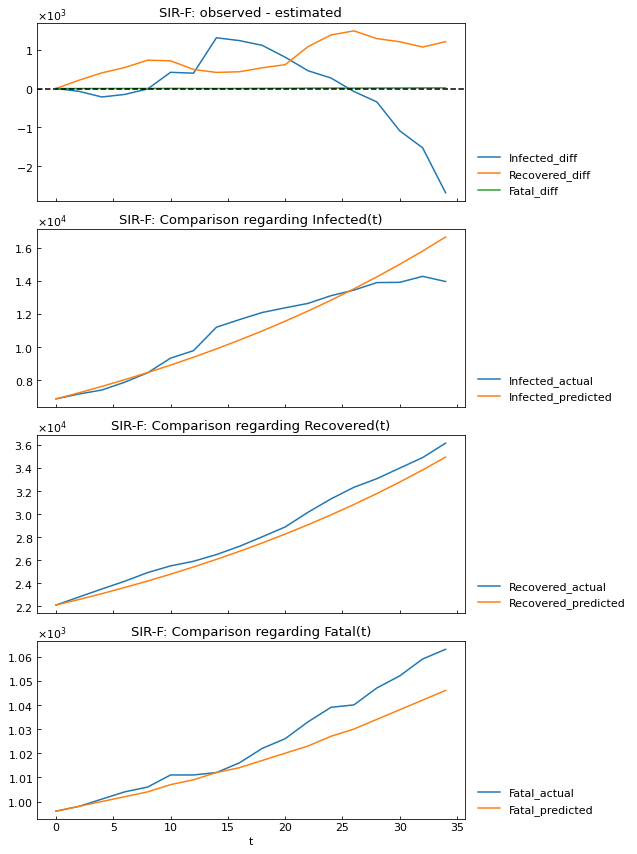

In [16]:
# Visualize the accuracy for the 2nd phase
snl.estimate_accuracy(phase="2nd")
# phase="last" means the last phases
# snl.estimate_accuracy(phase="last")

Total score can be retrived with `Scenario.score()` method.

In [17]:
# Get total score: metrics="MAE", "MSE", "MSLE", "RMSE" or "RMSLE"
# snl.score(metrics="RMSLE")
metrics_list = ["MAE", "MSE", "MSLE", "RMSE", "RMSLE"]
for metrics in metrics_list:
    metrics_name = metrics.rjust(len(max(metrics_list, key=len)))
    print(f"{metrics_name}: {snl.score(metrics=metrics):.3f}")

  MAE: 595.340


  MSE: 1226817.013


 MSLE: 0.077


 RMSE: 920.233


RMSLE: 0.278


### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [18]:
# Get parameter values
snl.get("Rt", phase="4th")

0.91

In [19]:
# phase="last" means the last phases
snl.get("Rt", phase="last")

0.6

### Show parameter history
We can get the history of parameter values with a dataframe and a figure.

In [20]:
# Get the parameter values as a dataframe
snl.summary(columns=[*cs.SIRF.PARAMETERS, "Rt"])

,theta,kappa,rho,sigma,Rt
0th,0.017203,0.000284,0.049220,0.007931,5.89
1st,0.047268,0.000508,0.021406,0.031197,0.64
2nd,0.000824,0.000085,0.060365,0.034138,1.76
3rd,0.000197,0.000568,0.038515,0.048723,0.78
4th,0.000791,0.000557,0.044613,0.048547,0.91
5th,0.000447,0.000596,0.053973,0.045678,1.17
6th,0.001074,0.000235,0.064778,0.038355,1.68
7th,0.000349,0.000709,0.049361,0.041837,1.16
8th,0.015486,0.000070,0.051766,0.041480,1.23
9th,0.000394,0.000815,0.050140,0.038165,1.29


`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

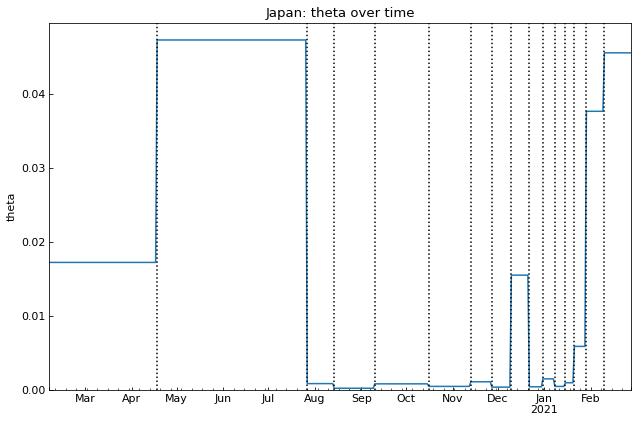

In [21]:
_ = snl.history(target="theta", show_legend=False)

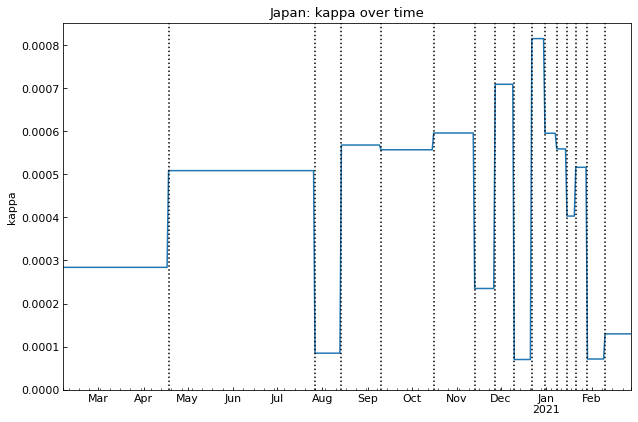

In [22]:
_ = snl.history(target="kappa", show_legend=False)

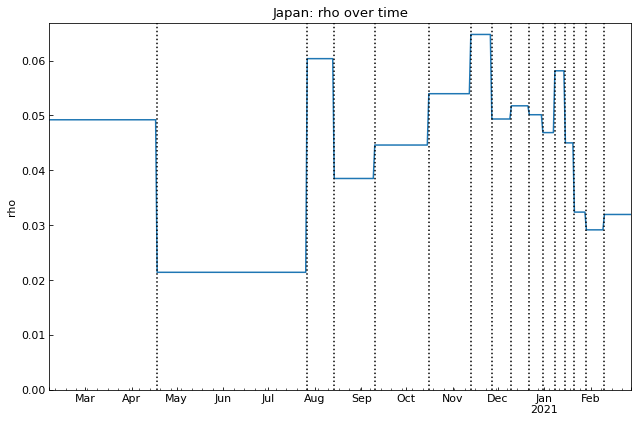

In [23]:
_ = snl.history(target="rho", show_legend=False)

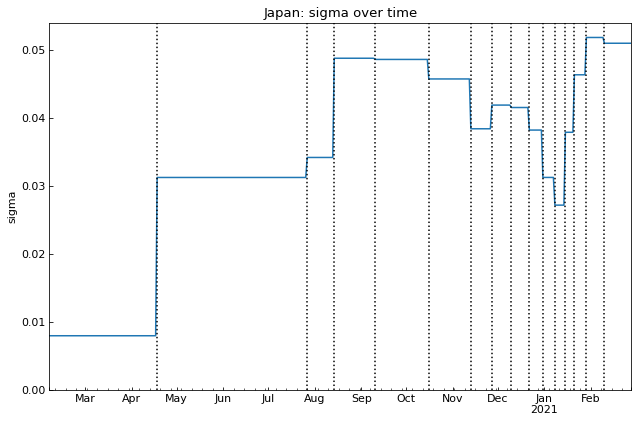

In [24]:
_ = snl.history(target="sigma", show_legend=False)

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

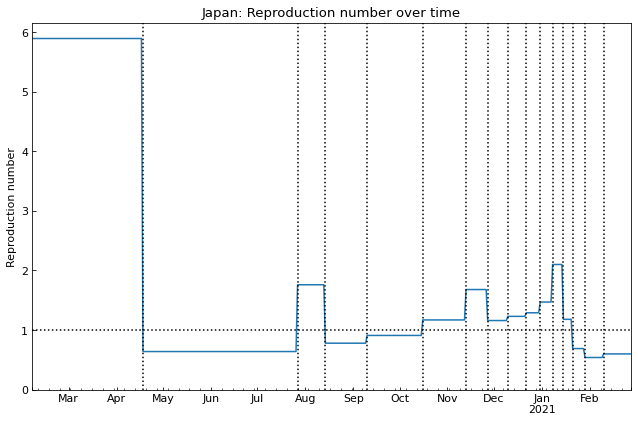

In [25]:
_ = snl.history(target="Rt", show_legend=False)

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

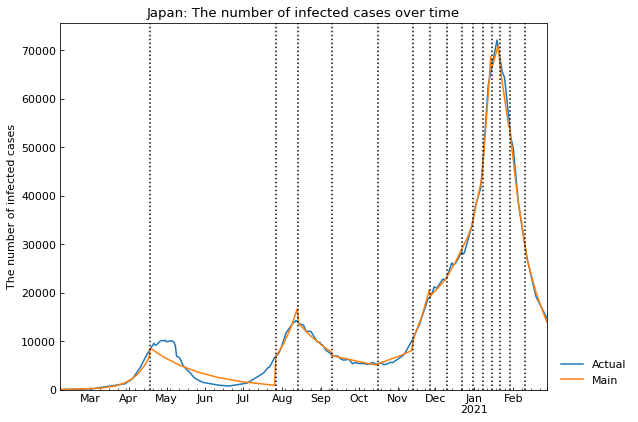

In [26]:
# Compare the actual values and the main scenario
_ = snl.history("Infected")

When we want to show only one scenario with all variables, we use `Scenario.simulate()` method.

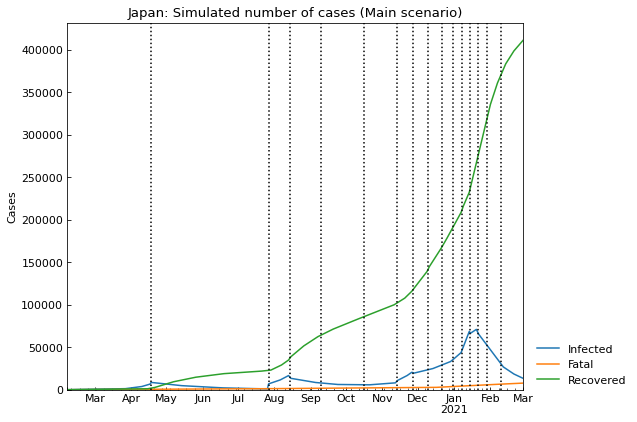

In [27]:
# Default variables and all phases for main scenario
_ =snl.simulate(name="Main")

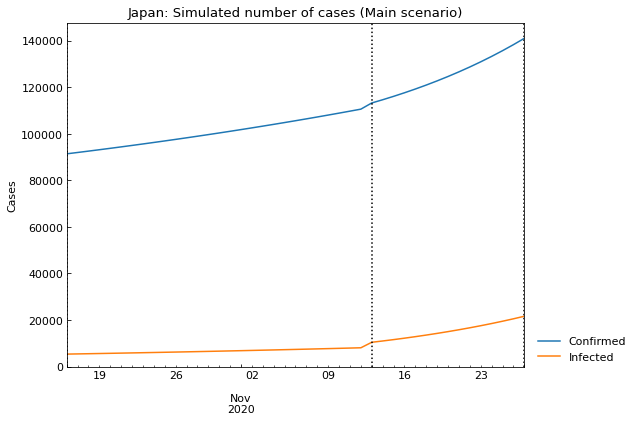

In [28]:
# We canselect variables and phases
_ = snl.simulate(name="Main", variables=["Confirmed", "Infected"], phases=["5th", "6th"])

### Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

i.e. If the parameter velues will not be changed until 01Jun2021, how many cases will be? We call this scenario as "Main" scenario.

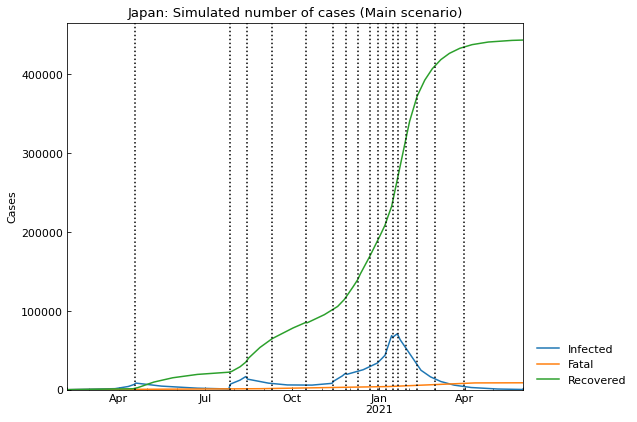

,Date,Confirmed,Fatal,Infected,Recovered
478,2021-05-29,452510,8756,336,443418
479,2021-05-30,452531,8757,322,443452
480,2021-05-31,452551,8758,309,443484
481,2021-06-01,452570,8759,297,443514
482,2021-06-02,452589,8760,285,443544


In [29]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30, name="Main")
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Jun2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be changed in the future phases.

If $\sigma$ will be 1.2 times in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [30]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.050926315968355215

In [31]:
# Sigma value will be double
sigma_new = sigma_current * 1.2
sigma_new

0.06111157916202625

In [32]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Jun2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Jun2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,5.89,0.017203,0.000284,0.049220,0.007931,720,0.017,1761,10,63,0.310062,628,1 min 11 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.64,0.047268,0.000508,0.021406,0.031197,720,0.047,983,23,16,0.479196,1531,3 min 2 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.76,0.000824,0.000085,0.060365,0.034138,720,0.001,5900,8,14,0.0457612,1618,3 min 2 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000197,0.000568,0.038515,0.048723,720,0.000,880,12,10,0.0249439,591,1 min 10 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.91,0.000791,0.000557,0.044613,0.048547,720,0.001,898,11,10,0.0289624,366,0 min 40 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.17,0.000447,0.000596,0.053973,0.045678,720,0.000,839,9,10,0.0551134,670,1 min 21 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.68,0.001074,0.000235,0.064778,0.038355,720,0.001,2128,7,13,0.0191845,660,1 min 31 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.16,0.000349,0.000709,0.049361,0.041837,720,0.000,705,10,11,0.0168537,184,0 min 20 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.23,0.015486,0.000070,0.051766,0.041480,720,0.015,7134,9,12,0.0140744,373,0 min 40 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.29,0.000394,0.000815,0.050140,0.038165,720,0.000,613,9,13,0.0158984,880,1 min 31 sec


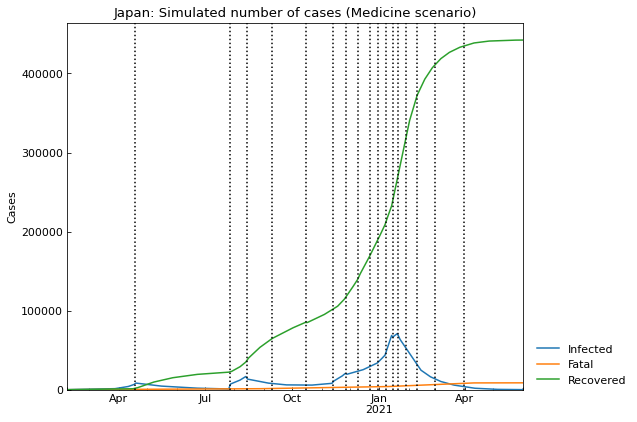

In [33]:
# Simulate the number of cases
_ = snl.simulate(name="Medicine").tail()

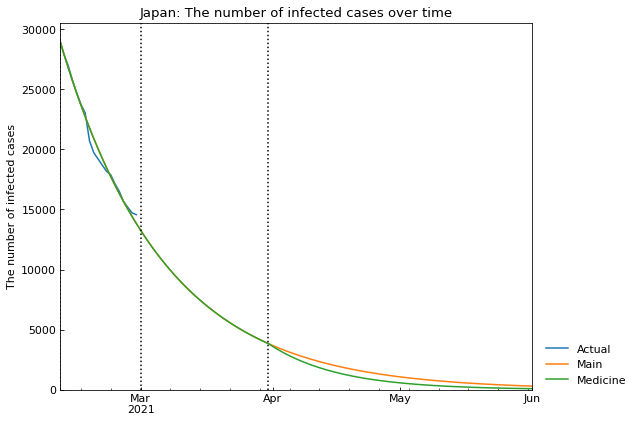

In [34]:
# Compare the number of cases with main scenario for the last two phases
all_phases = snl.summary(name="Medicine").index.tolist()
# Should start with a past phase: the last phase, the first and the second future phase
_ = snl.history("Infected", phases=all_phases[-3:])

### Short-term prediction of parameter values
With extra datasets, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures), vaccinations and so on impact on parameter values with the delay period. Delay period will be calculated with `cenario.estimate_delay()` automatically.

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [35]:
# Create Forecast scenario (copy Main scenario and delete future phases)
snl.clear(name="Forecast", template="Main")
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']:.3f} (train)")
print(f"Determination coefficient: {fit_dict['score_test']:.3f} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.273 (train)
Determination coefficient: 0.301 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Tests,Vaccinations,Vaccinated_once,Vaccinated_full
theta,0.016523,0.038201,-0.045844,0.000000,0.002454,0.014919,0.019398,0.030281,0.000000,-0.053881,0.000000,-0.003531,0.000000,0.000000,0.000000
kappa,-0.000000,0.000323,0.000091,0.000000,0.000163,0.000278,-0.000444,-0.000410,0.000000,-0.000029,0.000000,-0.000242,0.000000,0.000000,0.000000
rho,-0.008435,-0.038419,0.039662,0.000000,-0.009894,-0.015831,-0.011376,-0.023847,0.000000,0.027368,0.000000,0.022743,0.000000,0.000000,0.000000
sigma,-0.004857,0.025190,-0.022001,0.000000,-0.015118,0.016581,0.002231,0.004246,0.000000,0.010566,0.000000,0.024971,0.000000,0.000000,0.000000


In [36]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,5.89,0.017203,0.000284,0.049220,0.007931,720,0.017,1761,10,63,0.310062,628,1 min 11 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.64,0.047268,0.000508,0.021406,0.031197,720,0.047,983,23,16,0.479196,1531,3 min 2 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.76,0.000824,0.000085,0.060365,0.034138,720,0.001,5900,8,14,0.0457612,1618,3 min 2 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000197,0.000568,0.038515,0.048723,720,0.000,880,12,10,0.0249439,591,1 min 10 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.91,0.000791,0.000557,0.044613,0.048547,720,0.001,898,11,10,0.0289624,366,0 min 40 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.17,0.000447,0.000596,0.053973,0.045678,720,0.000,839,9,10,0.0551134,670,1 min 21 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.68,0.001074,0.000235,0.064778,0.038355,720,0.001,2128,7,13,0.0191845,660,1 min 31 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.16,0.000349,0.000709,0.049361,0.041837,720,0.000,705,10,11,0.0168537,184,0 min 20 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.23,0.015486,0.000070,0.051766,0.041480,720,0.015,7134,9,12,0.0140744,373,0 min 40 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.29,0.000394,0.000815,0.050140,0.038165,720,0.000,613,9,13,0.0158984,880,1 min 31 sec


In [37]:
# Or, when you do not need 'fit_dict',
# snl.fit_predict(name="Forecast").summary(name="Forecast")

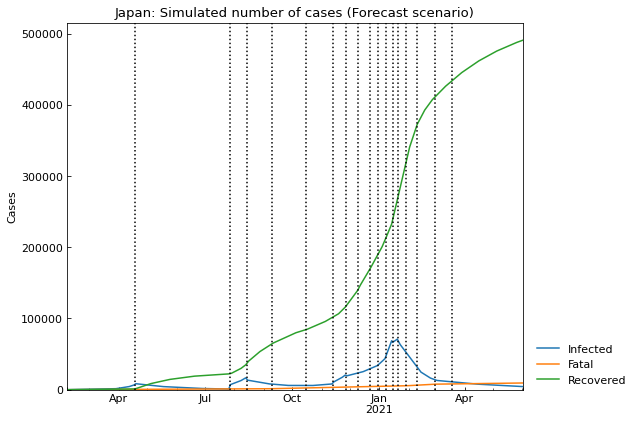

In [38]:
# Set 01Jun2021 as tthe last date of the future
snl.add(name="Forecast", end_date="01Jun2021")
# Simulate the number of cases
_ = snl.simulate(name="Forecast").tail()

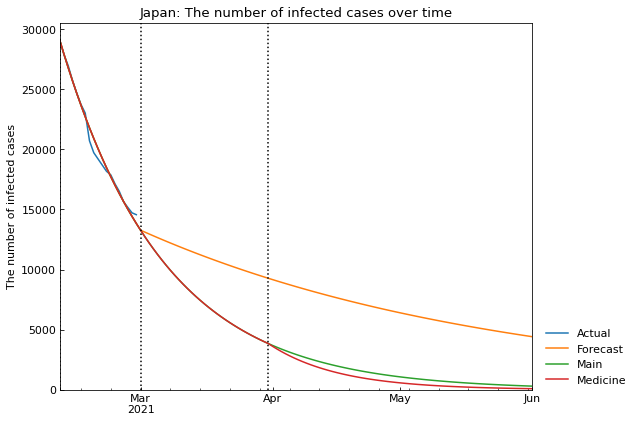

In [39]:
# Compare the number of cases with main scenario for the last two phases
all_phases = snl.summary(name="Forecast").index.tolist()
# Should start with a past phase: the last phase, the first and the second future phase
_ = snl.history("Infected", phases=all_phases[-3:])

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values. Currently, we can compare the scenarios with the following indexes.

- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on …: Infected on the end date of the last phase
- Fatal on …: Fatal on the end date of the last phase

In [40]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Jun2021,Infected on 02Jun2021,Fatal on 02Jun2021,16th_Rt,17th_Rt
Main,70969,20Jan2021,452589,285,8760,0.60,0.60
Medicine,70969,20Jan2021,450993,79,8681,0.60,0.50
Forecast,70969,20Jan2021,504719,4358,9426,0.89,0.89


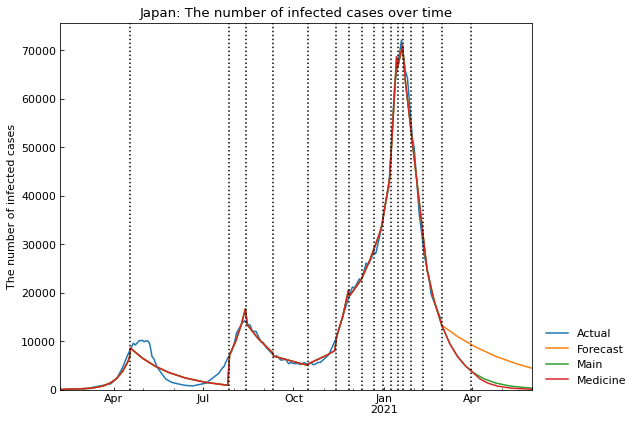

In [41]:
_ = snl.history(target="Infected")

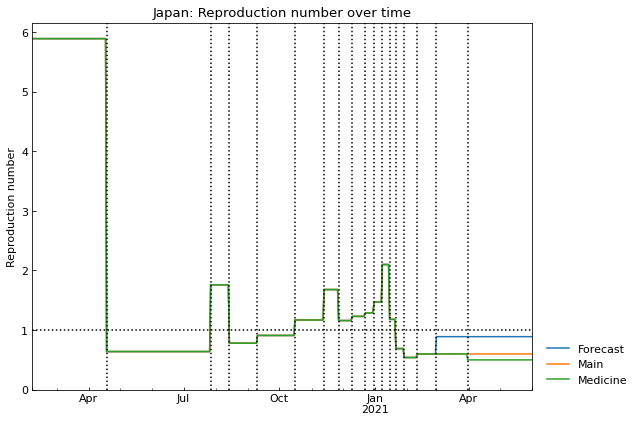

In [42]:
_ = snl.history(target="Rt")

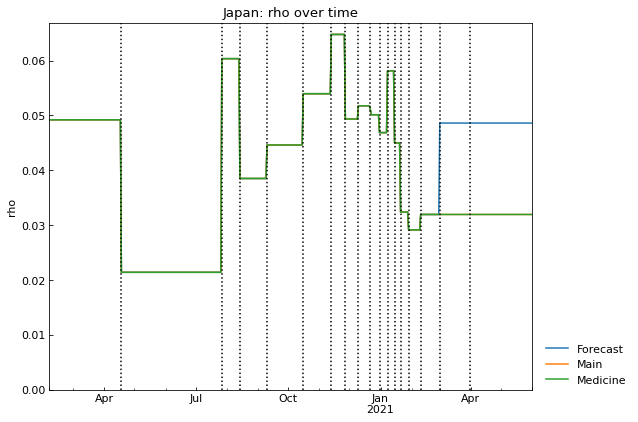

In [43]:
_ = snl.history(target="rho")

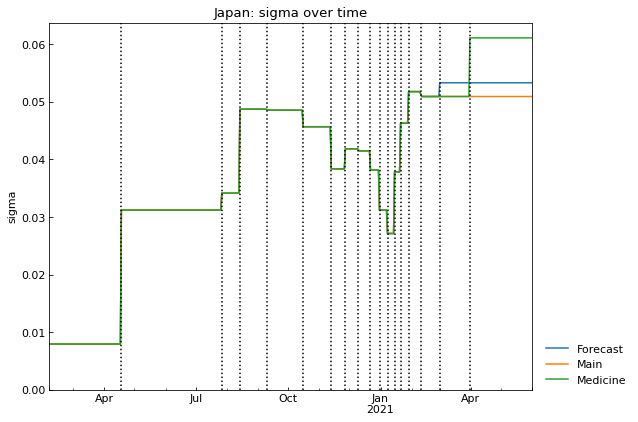

In [44]:
_ = snl.history(target="sigma")

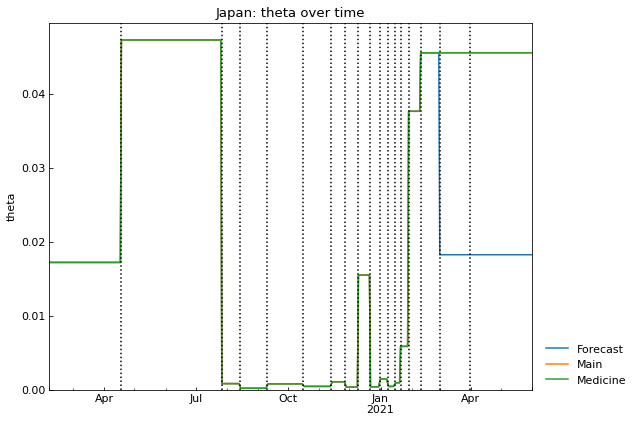

In [45]:
_ = snl.history(target="theta")

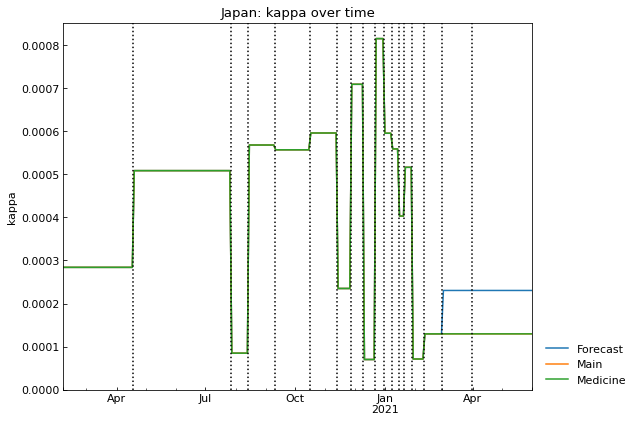

In [46]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

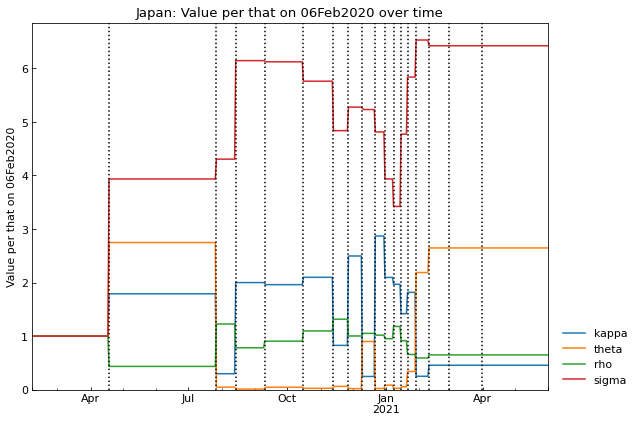

In [47]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [48]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective(
    "01Jan2021", model=cs.SIRF, control="Main", target="Retrospective", timeout=10)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	15th phase (10Feb2021 - 28Feb2021): finished  128 trials in 0 min 10 sec


	 1st phase (18Apr2020 - 26Jul2020): finished  100 trials in 0 min 10 sec

	 2nd phase (27Jul2020 - 13Aug2020): finished   89 trials in 0 min 10 sec

	 3rd phase (14Aug2020 - 09Sep2020): finished   89 trials in 0 min 10 sec

	 5th phase (16Oct2020 - 12Nov2020): finished   86 trials in 0 min 10 sec

	 4th phase (10Sep2020 - 15Oct2020): finished  115 trials in 0 min 10 sec

	 6th phase (13Nov2020 - 26Nov2020): finished  122 trials in 0 min 10 sec

	 0th phase (06Feb2020 - 17Apr2020): finished  100 trials in 0 min 10 sec

	 7th phase (27Nov2020 - 09Dec2020): finished  100 trials in 0 min 10 sec

	 8th phase (10Dec2020 - 21Dec2020): finished  106 trials in 0 min 10 sec

	 9th phase (22Dec2020 - 30Dec2020): finished  113 trials in 0 min 10 sec

	11th phase (08Jan2021 - 14Jan2021): finished  109 trials in 0 min 10 sec

	10th phase (31Dec2020 - 07Jan2021): finished  111 trials in 0 min 10 sec

	12th phase (15Jan2021 - 20Jan2021): finished  107 trials in 0 min 10 sec

	13th phase (21Jan2021 - 28Jan2021): finished  110 trials in 0 min 10 sec

	14th phase (29Jan2021 - 09Feb2021): finished  113 trials in 0 min 10 sec

Completed optimization. Total: 0 min 35 sec



<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	10th phase (31Dec2020 - 28Feb2021): finished  420 trials in 0 min 10 sec

Completed optimization. Total: 0 min 13 sec


In [49]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  17Apr2020  SIR-F  5.78  0.064913  0.000828   
              1st    18Apr2020  26Jul2020  SIR-F  0.63  0.040459  0.000184   
              2nd    27Jul2020  13Aug2020  SIR-F  1.52  0.023216  0.000557   
              3rd    14Aug2020  09Sep2020  SIR-F  0.68  0.027397  0.001819   
              4th    10Sep2020  15Oct2020  SIR-F  0.92  0.003232  0.000309   
              5th    16Oct2020  12Nov2020  SIR-F  1.29  0.023216  0.000557   
              6th    13Nov2020  26Nov2020  SIR-F  1.63  0.023216  0.000557   
              7th    27Nov2020  09Dec2020  SIR-F  1.20  0.003232  0.000309   
              8th    10Dec2020  21Dec2020  SIR-F  1.22  0.023216  0.000557   
              9th    22Dec2020  30Dec2020  SIR-F  1.25  0.023216  0.000557   
              10th   31Dec2020  07Jan2021  SIR-F  1.45  0.003232  0.000309   
              11th   08Jan2021  14Jan2021  SIR-F  1.84  0.023216  0.000557   
              12th   15Jan2021  20Jan2021  SIR-F  1.03  0.027397  0.001819   
              13th   21Jan2021  28Jan2021  SIR-F  0.64  0.027397  0.001819   
              14th   29Jan2021  09Feb2021  SIR-F  0.55  0.030618  0.000109   
              15th   10Feb2021  28Feb2021  SIR-F  0.36  0.502086  0.000039   
Retrospective 0th    06Feb2020  17Apr2020  SIR-F  5.78  0.064913  0.000828   
              1st    18Apr2020  26Jul2020  SIR-F  0.63  0.040459  0.000184   
              2nd    27Jul2020  13Aug2020  SIR-F  1.52  0.023216  0.000557   
              3rd    14Aug2020  09Sep2020  SIR-F  0.68  0.027397  0.001819   
              4th    10Sep2020  15Oct2020  SIR-F  0.92  0.003232  0.000309   
              5th    16Oct2020  12Nov2020  SIR-F  1.29  0.023216  0.000557   
              6th    13Nov2020  26Nov2020  SIR-F  1.63  0.023216  0.000557   
              7th    27Nov2020  09Dec2020  SIR-F  1.20  0.003232  0.000309   
              8th    10Dec2020  21Dec2020  SIR-F  1.22  0.023216  0.000557   
              9th    22Dec2020  30Dec2020  SIR-F  1.25  0.023216  0.000557   
              10th   31Dec2020  28Feb2021  SIR-F  1.25  0.023216  0.000557   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.020289  0.002456  0.819396     100  0 min 10 sec  
              1st    0.010726  0.016182  0.575994     100  0 min 10 sec  
              2nd    0.023211  0.014400  0.215977      89  0 min 10 sec  
              3rd    0.016363  0.021452  0.445573      89  0 min 10 sec  
              4th    0.019481  0.020709  0.047331     115  0 min 10 sec  
              5th    0.023593  0.017340  0.174477      86  0 min 10 sec  
              6th    0.026891  0.015568  0.132906     122  0 min 10 sec  
              7th    0.021977  0.017995  0.023897     100  0 min 10 sec  
              8th    0.021453  0.016634  0.110626     106  0 min 10 sec  
              9th    0.021654  0.016408  0.084157     113  0 min 10 sec  
              10th   0.021058  0.014123  0.018169     111  0 min 10 sec  
              11th   0.021257  0.010731  0.104011     109  0 min 10 sec  
              12th   0.018154  0.015372  0.213133     107  0 min 10 sec  
              13th   0.014393  0.019961  0.217064     110  0 min 10 sec  
              14th   0.012748  0.022216  0.021740     113  0 min 10 sec  
              15th   0.014139  0.019725  0.373734     128  0 min 10 sec  
Retrospective 0th    0.020289  0.002456  0.819396     100  0 min 10 sec  
              1st    0.010726  0.016182  0.575994     100  0 min 10 sec  
              2nd    0.023211  0.014400  0.215977      89  0 min 10 sec  
              3rd    0.016363  0.021452  0.445573      89  0 min 10 sec  
              4th    0.019481  0.020709  0.047331     115  0 min 10 sec  
              5th    0.023593  0.017340  0.174477      86  0

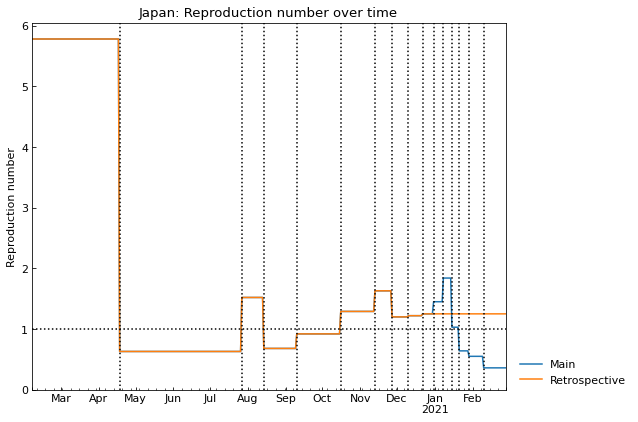

In [50]:
# History of reproduction number
_ = snl_retro.history("Rt")

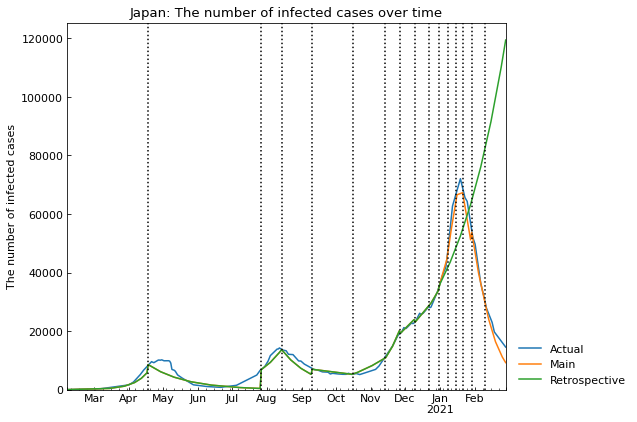

In [51]:
# History of Infected
_ = snl_retro.history("Infected")

In [52]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 01Mar2021,Infected on 01Mar2021,Fatal on 01Mar2021,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt,15th_Rt
Main,67291,21Jan2021,430764,8672,17955,1.45,1.84,1.03,0.64,0.55,0.36
Retrospective,121869,01Mar2021,684081,121869,25658,1.25,-,-,-,-,-
